In [ ]:
!pip install prophet --quiet

In [33]:
#prophet with train and test data
import pandas as pd
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score

#forecast settings
forecast_steps = 17280  #6 months of 15-min intervals
cell_col = "NCI"
timestamp_col = "Timestamp"
test_ratio = 0.2  #20% for testing

def forecast_with_prophet(df, kpi_col, output_path):
    all_forecasts = []
    accuracy_records = []

    for cell in df["NCI"].unique():
        print(f"\nForecasting for cell {cell} | KPI: {kpi_col}")

        cell_df = df[df["NCI"] == cell][["Timestamp", kpi_col]].dropna()

        # Parse Timestamp column properly based on your format (e.g., "01-01-2025 00:00")
        try:
            cell_df["Timestamp"] = pd.to_datetime(cell_df["Timestamp"], format="%m-%d-%Y %H:%M", errors='coerce')
            cell_df = cell_df.dropna().sort_values("Timestamp")
        except Exception as e:
            print(f"Failed to parse timestamps for cell {cell}: {e}")
            continue

        ts = cell_df.rename(columns={"Timestamp": "ds", kpi_col: "y"})

        # Split into train and test
        '''split_idx = int(len(ts) * 0.8)
        train_df = ts.iloc[:split_idx]
        test_df = ts.iloc[split_idx:]'''
        split_time = ts["ds"].quantile(1 - test_ratio)
        train_df = ts[ts["ds"] < split_time]
        test_df = ts[ts["ds"] >= split_time]

        # Initialize and fit Prophet model with clear seasonality
        model = Prophet(daily_seasonality=False, weekly_seasonality=False)
        model.add_seasonality(name='daily', period=1, fourier_order=8)
        model.add_seasonality(name='weekly', period=7, fourier_order=5)
        model.fit(train_df)

        # Evaluate on test set
        forecast_test = model.predict(test_df[["ds"]])
        accuracy = r2_score(test_df["y"], forecast_test["yhat"]) * 100
        print(f"Test Accuracy for cell {cell}: {accuracy:.2f}%")

        accuracy_records.append({
            "Cell": cell,
            "KPI": kpi_col,
            "Accuracy(%)": round(accuracy, 2)
        })

        forecast_start = pd.Timestamp("2025-05-02 00:00:00")
        forecast_end = pd.Timestamp("2025-11-01 23:45:00")

        # Build future_df manually from desired start
        last_train_date = ts["ds"].max()
        full_future_df = model.make_future_dataframe(periods=0)  # just returns training timestamps

        # Now append desired forecast future
        future_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="15min")
        future_df = pd.concat([full_future_df, pd.DataFrame({"ds": future_dates})], ignore_index=True)
        forecast = model.predict(future_df)

        forecast_future = forecast[forecast["ds"] > ts["ds"].max()]

        forecast_future["nCI"] = cell
        forecast_future["KPI"] = kpi_col
        forecast_future.rename(columns={"ds": "Timestamp", "yhat": "Forecast"}, inplace=True)

        all_forecasts.append(forecast_future[["Timestamp", "Forecast", "nCI", "KPI"]])

    # Combine and save
    final_df = pd.concat(all_forecasts, ignore_index=True)
    final_df.to_csv(output_path, index=False)
    print(f"\nForecasts saved to: {output_path}")

    accuracy_df = pd.DataFrame(accuracy_records)
    accuracy_path = output_path.replace(".csv", "_accuracy.csv")
    accuracy_df.to_csv(accuracy_path, index=False)
    print(f"Accuracy report saved to: {accuracy_path}")

#load data
df_prb = pd.read_csv("/content/drive/MyDrive/DL_Prb_Utilization_Data.csv")
df_ue = pd.read_csv("/content/drive/MyDrive/Avg_UE_Number_Data.csv")


#run forecasting
forecast_with_prophet(df_prb, "DL_Prb_Utilization", "/content/drive/MyDrive/forecast_DL_Prb_Utilization_Prophet.csv")
forecast_with_prophet(df_ue, "Avg_UE_Number", "/content/drive/MyDrive/forecast_Avg_UE_Number_Prophet.csv")


Forecasting for cell 357783981 | KPI: DL_Prb_Utilization


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/esqqe9_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/w6w20a_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48099', 'data', 'file=/tmp/tmpmna7m7uv/esqqe9_4.json', 'init=/tmp/tmpmna7m7uv/w6w20a_p.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelagfltvr_/prophet_model-20250708180435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 357783981: 79.50%

Forecasting for cell 357783979 | KPI: DL_Prb_Utilization


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/4f06ir3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/jfi7k5pg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61888', 'data', 'file=/tmp/tmpmna7m7uv/4f06ir3f.json', 'init=/tmp/tmpmna7m7uv/jfi7k5pg.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelcljvu3y8/prophet_model-20250708180448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 357783979: 79.85%

Forecasting for cell 357783980 | KPI: DL_Prb_Utilization


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/z7djm9s4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/m4v2da1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82188', 'data', 'file=/tmp/tmpmna7m7uv/z7djm9s4.json', 'init=/tmp/tmpmna7m7uv/m4v2da1k.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelstyw9zpb/prophet_model-20250708180500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 357783980: 80.38%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/3mq6ndmb.json



Forecasting for cell 358531244 | KPI: DL_Prb_Utilization


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/pu8dejul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75529', 'data', 'file=/tmp/tmpmna7m7uv/3mq6ndmb.json', 'init=/tmp/tmpmna7m7uv/pu8dejul.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelmuyb6nwu/prophet_model-20250708180511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 358531244: 79.75%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/zrjrzegt.json



Forecasting for cell 358531245 | KPI: DL_Prb_Utilization


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/13y33jzg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72295', 'data', 'file=/tmp/tmpmna7m7uv/zrjrzegt.json', 'init=/tmp/tmpmna7m7uv/13y33jzg.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelockblnvh/prophet_model-20250708180524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 358531245: 80.46%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/qd003xge.json



Forecasting for cell 358531243 | KPI: DL_Prb_Utilization


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/x8mn3r7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63996', 'data', 'file=/tmp/tmpmna7m7uv/qd003xge.json', 'init=/tmp/tmpmna7m7uv/x8mn3r7r.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelb9ssa5ha/prophet_model-20250708180538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 358531243: 79.72%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/_n3xs1fo.json



Forecasts saved to: /content/drive/MyDrive/forecast_DL_Prb_Utilization_Prophet.csv
Accuracy report saved to: /content/drive/MyDrive/forecast_DL_Prb_Utilization_Prophet_accuracy.csv

Forecasting for cell 357783981 | KPI: Avg_UE_Number


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/2we7hmqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64309', 'data', 'file=/tmp/tmpmna7m7uv/_n3xs1fo.json', 'init=/tmp/tmpmna7m7uv/2we7hmqg.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_model1queh5ql/prophet_model-20250708180550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 357783981: 73.49%

Forecasting for cell 357783979 | KPI: Avg_UE_Number


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/8fd2yeyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/6fvyxafg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73455', 'data', 'file=/tmp/tmpmna7m7uv/8fd2yeyi.json', 'init=/tmp/tmpmna7m7uv/6fvyxafg.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelps_uqyjo/prophet_model-20250708180602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 357783979: 72.80%

Forecasting for cell 357783980 | KPI: Avg_UE_Number


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/og33n245.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/c_saa9yy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77297', 'data', 'file=/tmp/tmpmna7m7uv/og33n245.json', 'init=/tmp/tmpmna7m7uv/c_saa9yy.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelhdip9dua/prophet_model-20250708180613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 357783980: 72.19%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/ppp93hl7.json



Forecasting for cell 358531244 | KPI: Avg_UE_Number


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/kxj2g57g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44007', 'data', 'file=/tmp/tmpmna7m7uv/ppp93hl7.json', 'init=/tmp/tmpmna7m7uv/kxj2g57g.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelm4bqgvbb/prophet_model-20250708180624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 358531244: 71.66%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/8xtjner6.json



Forecasting for cell 358531245 | KPI: Avg_UE_Number


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/ene9fppy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45370', 'data', 'file=/tmp/tmpmna7m7uv/8xtjner6.json', 'init=/tmp/tmpmna7m7uv/ene9fppy.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelt126bchx/prophet_model-20250708180635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 358531245: 72.48%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/6fv8yn9v.json



Forecasting for cell 358531243 | KPI: Avg_UE_Number


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmna7m7uv/4n2vitxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26663', 'data', 'file=/tmp/tmpmna7m7uv/6fv8yn9v.json', 'init=/tmp/tmpmna7m7uv/4n2vitxb.json', 'output', 'file=/tmp/tmpmna7m7uv/prophet_modelw13p63cu/prophet_model-20250708180646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Accuracy for cell 358531243: 71.66%

Forecasts saved to: /content/drive/MyDrive/forecast_Avg_UE_Number_Prophet.csv
Accuracy report saved to: /content/drive/MyDrive/forecast_Avg_UE_Number_Prophet_accuracy.csv


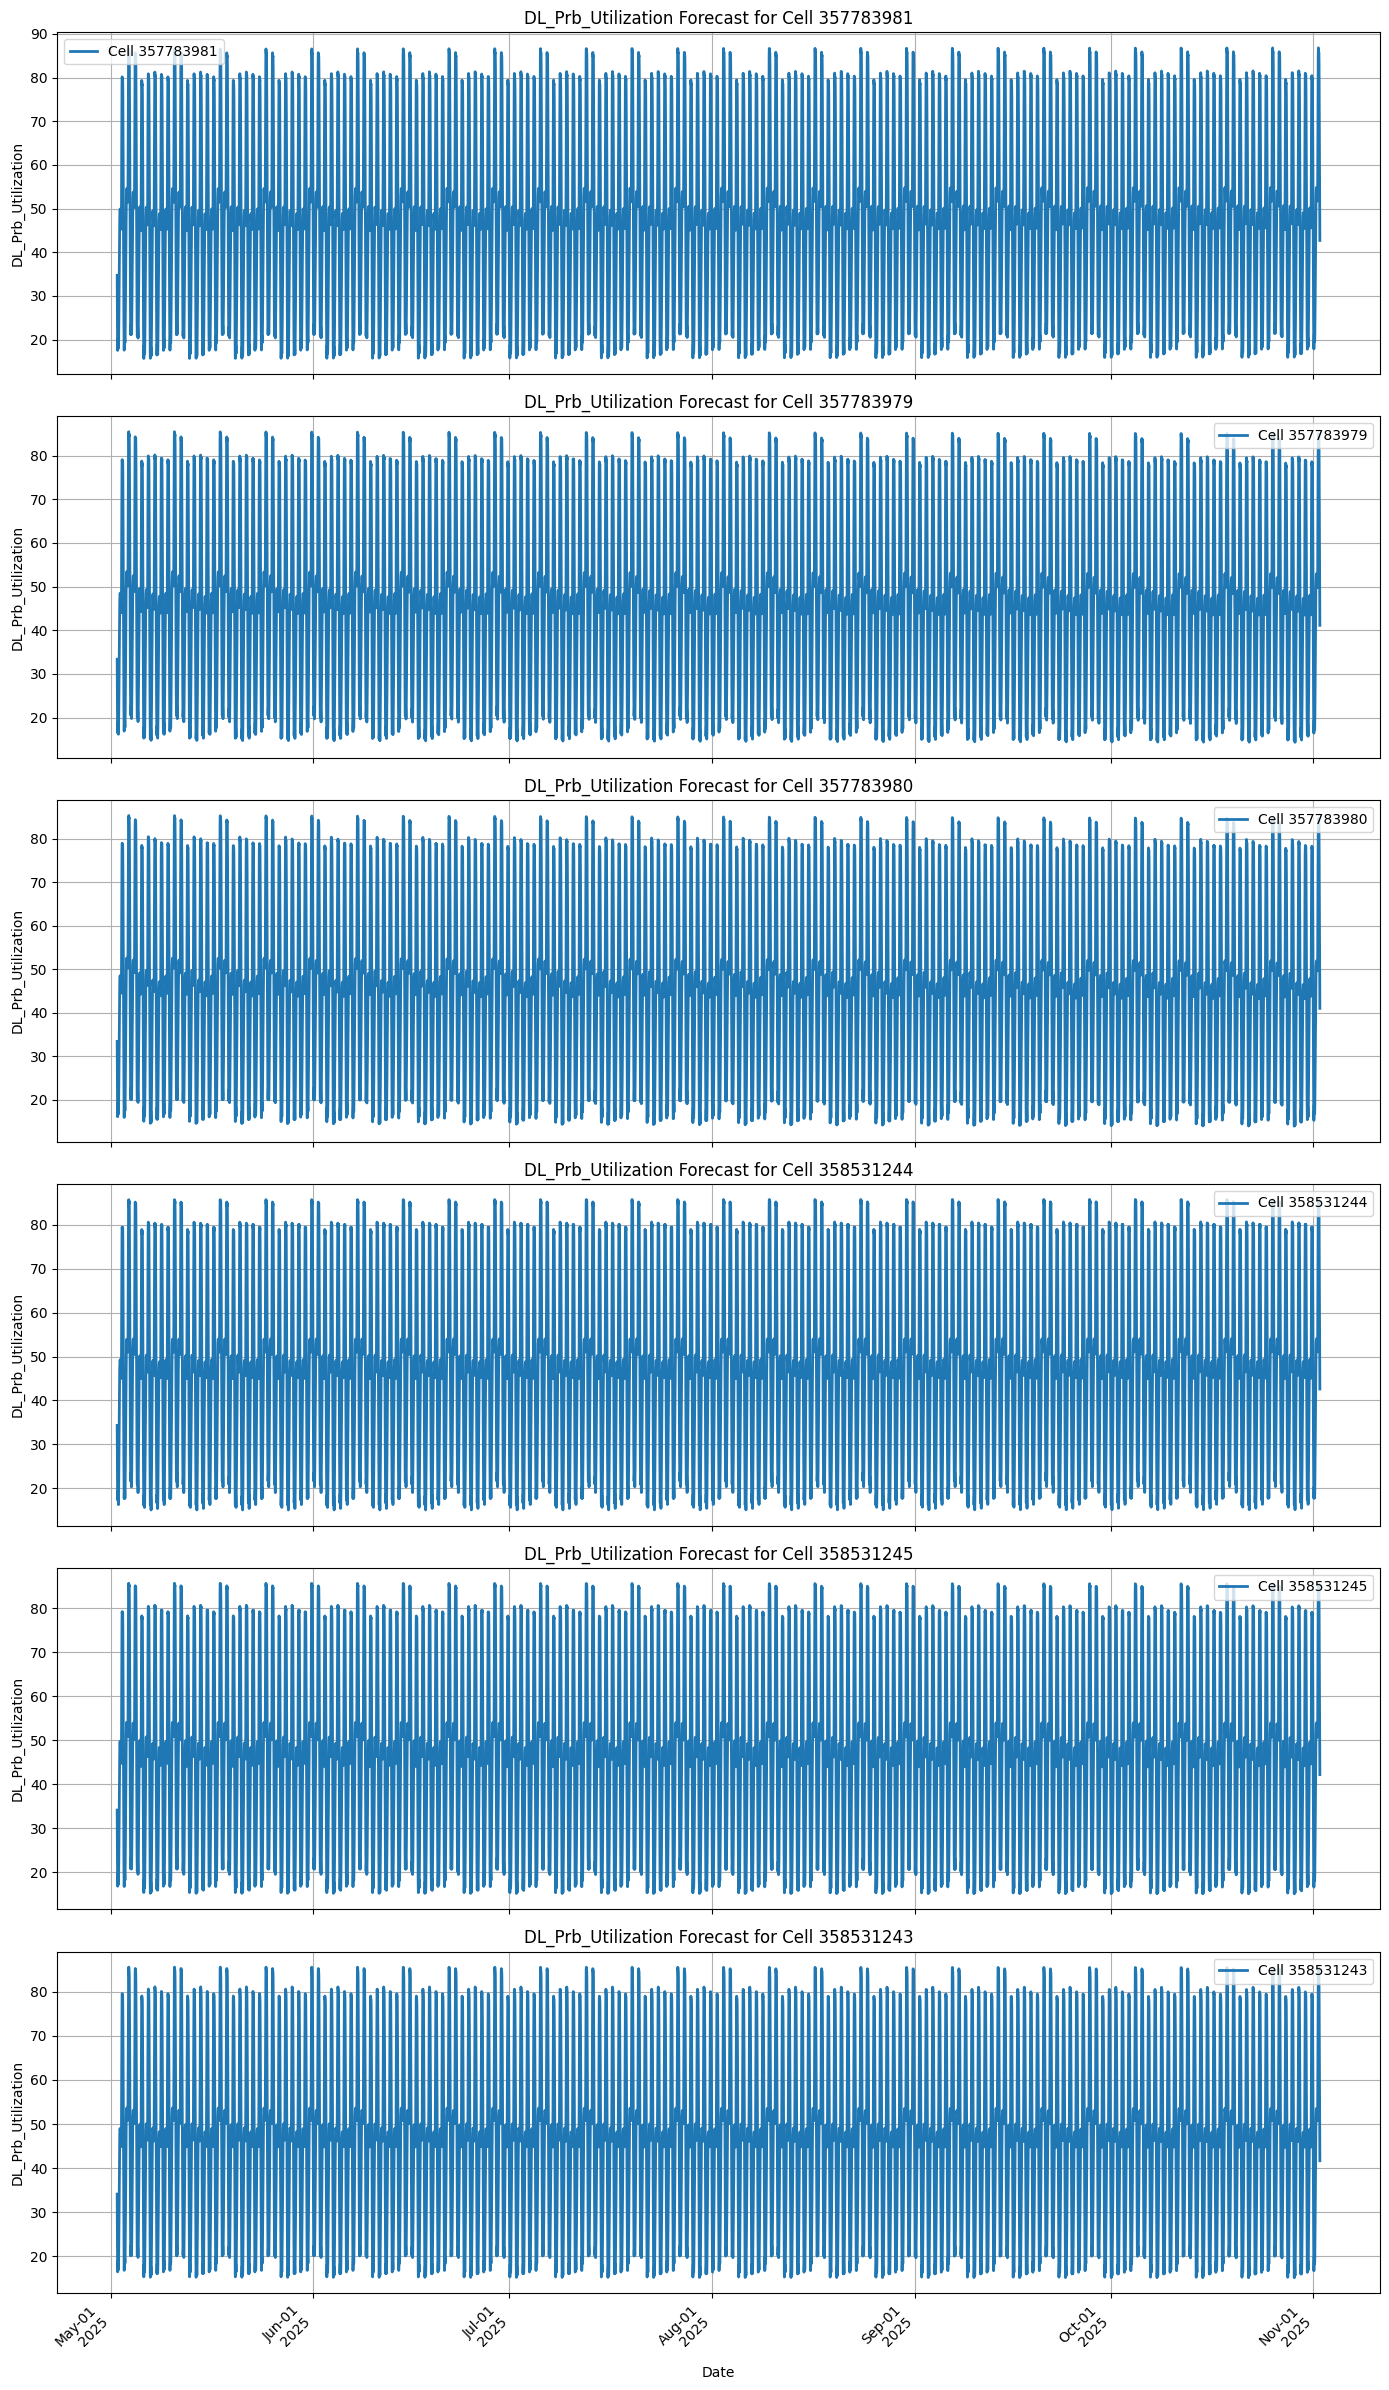

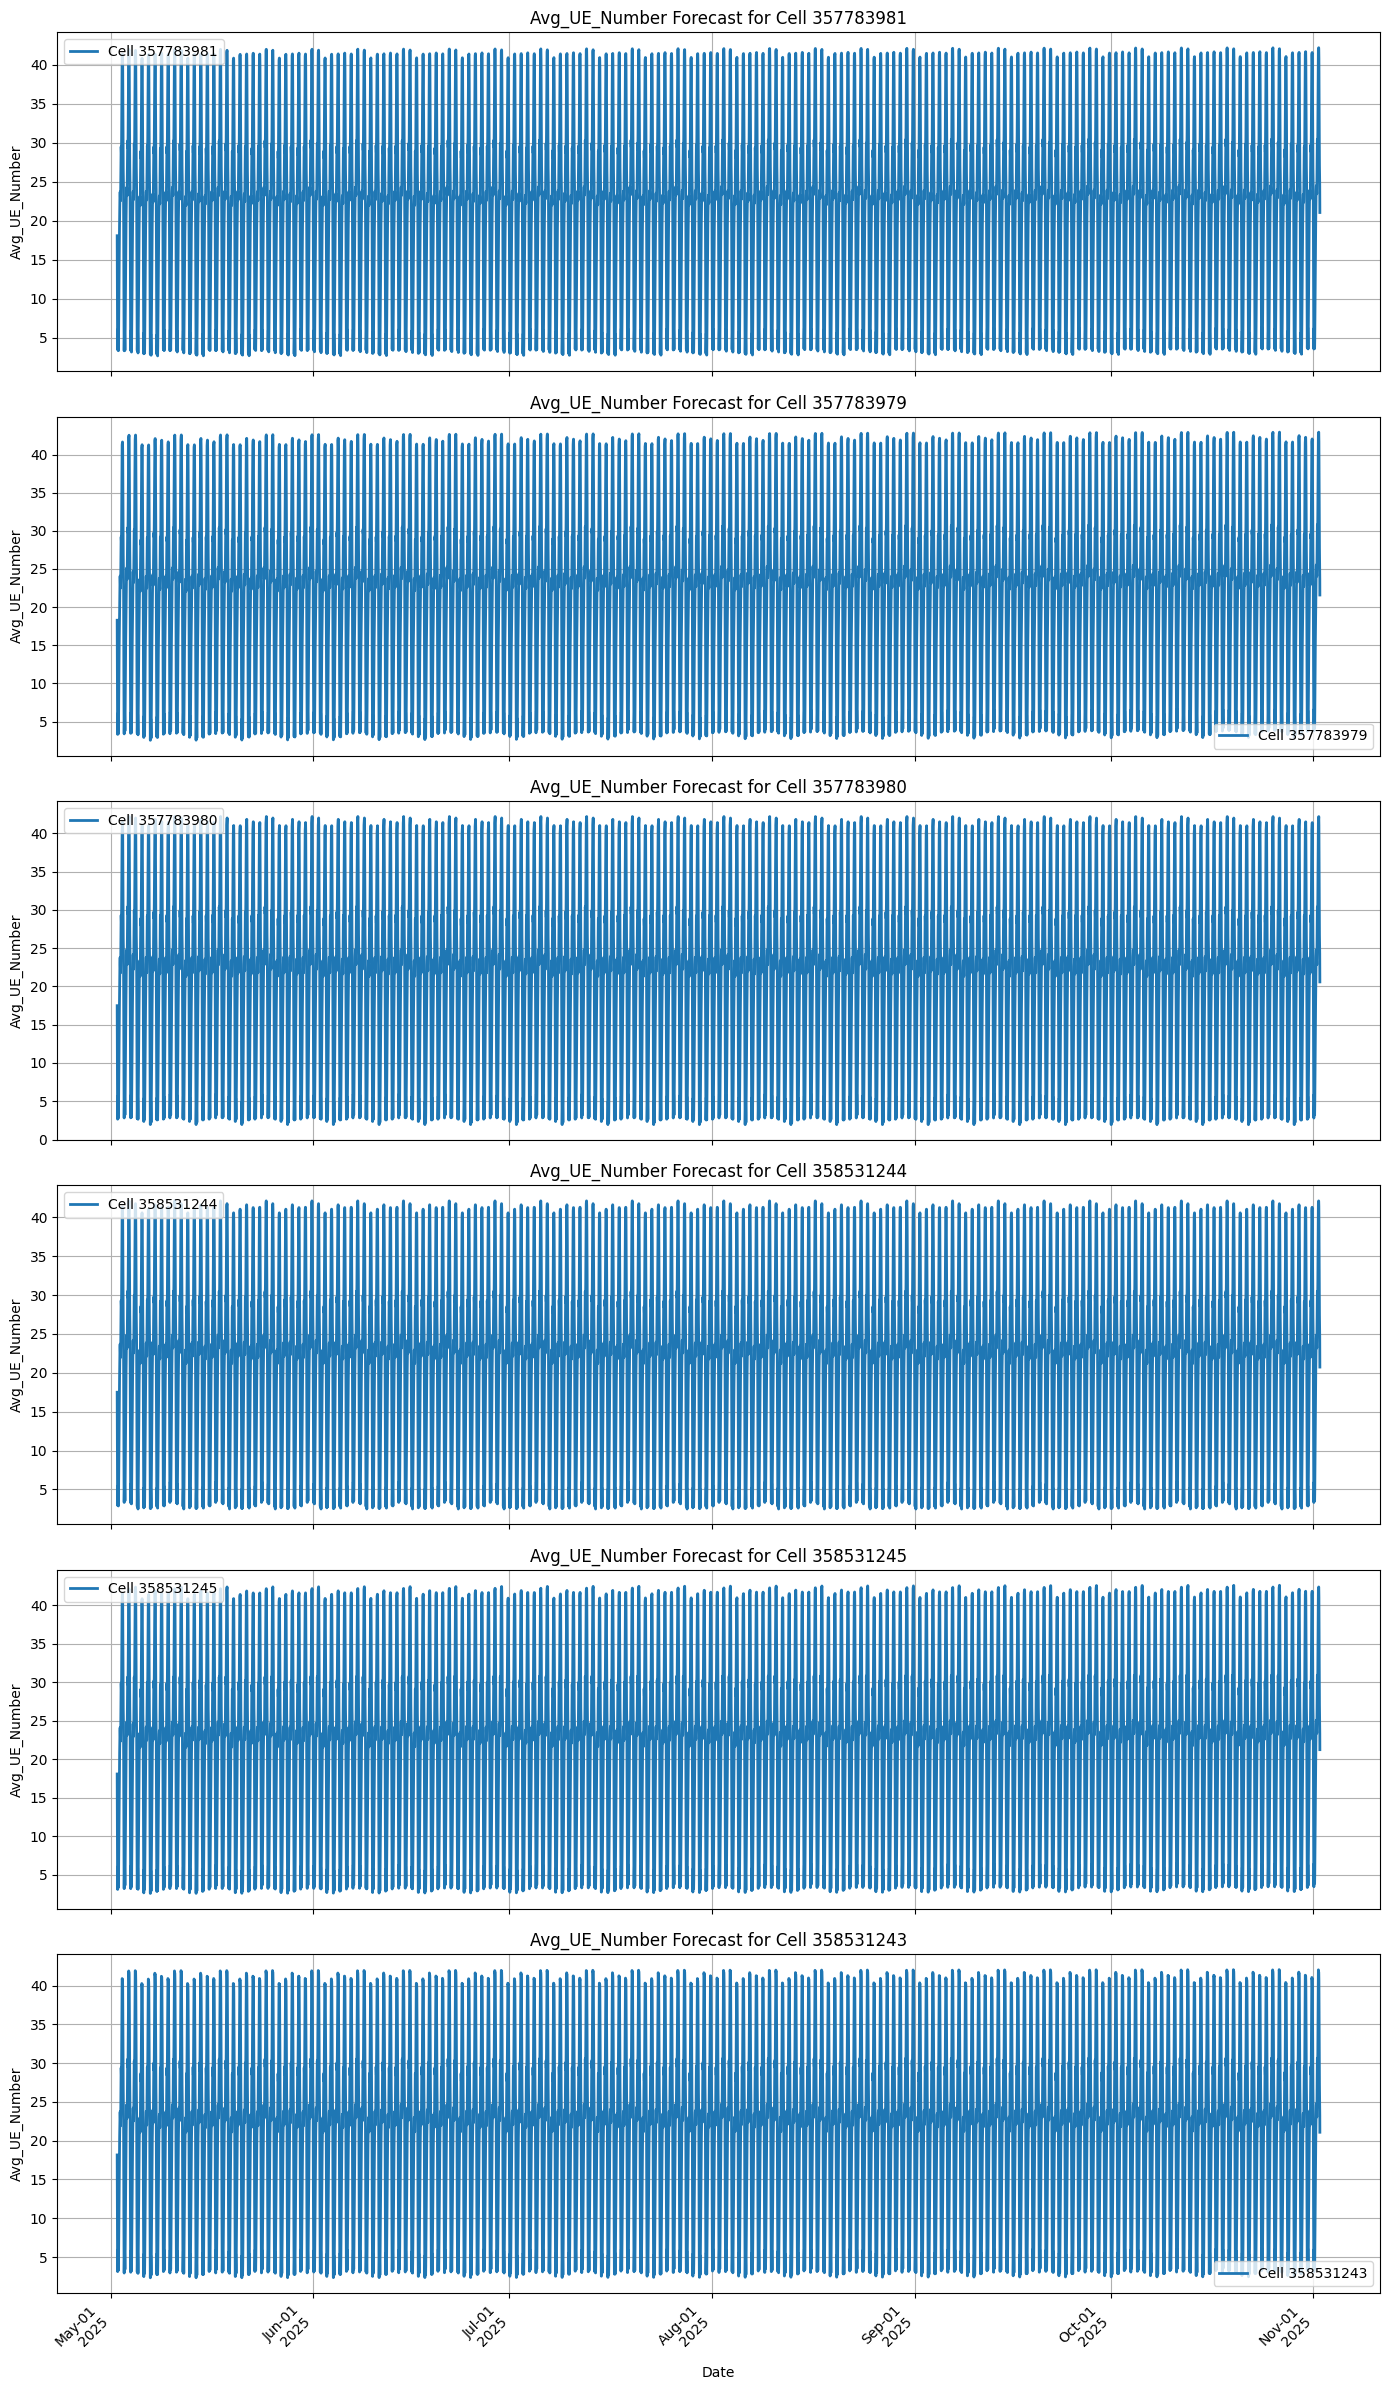

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_forecast(file_path, kpi_name):
    df_forecast = pd.read_csv(file_path)
    df_forecast["Timestamp"] = pd.to_datetime(df_forecast["Timestamp"])

    cells = df_forecast["nCI"].unique()
    num_cells = len(cells)

    fig, axes = plt.subplots(num_cells, 1, figsize=(14, 4 * num_cells), sharex=True)

    for i, cell in enumerate(cells):
        ax = axes[i]
        cell_data = df_forecast[df_forecast["nCI"] == cell]

        ax.plot(cell_data["Timestamp"], cell_data["Forecast"], label=f"Cell {cell}", linewidth=2)
        ax.set_title(f"{kpi_name} Forecast for Cell {cell}")
        ax.set_ylabel(kpi_name)
        ax.grid(True)
        ax.legend()

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d\n%Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

plot_forecast("/content/drive/MyDrive/forecast_DL_Prb_Utilization_Prophet.csv", "DL_Prb_Utilization")
plot_forecast("/content/drive/MyDrive/forecast_Avg_UE_Number_Prophet.csv", "Avg_UE_Number")